In [1]:
# You will usually perform all the imports at the beginning of the script
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

# Differential equation
Many problems can be represented as differential equations. You've just seen how the movement of 
classicla particles can be described by Newton's equation:

$$
m\frac{\partial^2 x(t)}{\partial t^2} = -\nabla_x V(x(t))
$$

- m : mass of the particles
- x : positions of the particles as a function of time
- V : potential that is a function of the positions
- t : time, the free variable

It this kind of problem, it's common for you to have the initial conditions of the problem, in this
case the position $x(0)$ and velocity $(\dot x)(0)$ at time 0, and then you want to know how it
evolves in time. Those are called the [Initial Value Problem](https://en.wikipedia.org/wiki/Initial_value_problem).

In this tutorial we will follow different ways to solve this IVP with python, with two foci:
- understanding this kind of problem because it is common for academic problems to be represented
this way
- practicing python with a more elaborated problem.

It's good to try to understand the general purpose of the following functions, but it will take
some time to understand the details of each operation.

# Numerical solution to the IVP
In computers, the numbers are not continuous, they are [floating points](https://en.wikipedia.org/wiki/Floating-point_arithmetic).
This means that when we want to evolve the time, I need to discretize it.

If we discretize the time from 0 to 2 seconds with a timestep equal to 0.5 s, then we will have the times:
- $t_0$ = 0.0 s
- $t_1$ = 0.5 s
- $t_2$ = 1.0 s
- $t_3$ = 1.5 s
- $t_4$ = 2.0 s

The size of the timestep and the method used to evolve the free variable will dictate the quality
of the solution.

## Euler method
Considering you have a differential equation that can be written as:

$$
y'(t) = f(t, y)
$$

and you know the values of time and y at step n (y_n, t_n). You can then aproximate the value of
y for the next step using a Taylor expansion:

$$\begin{align}
t_{n+1} &= t_n + \Delta t \\
y_{n+1} &= y_n + \Delta t \cdot y'_n \\
&= y_n + \Delta t \cdot f(t_n, y_n)
\end{align}$$

For each step in the evolution until the maximum time you repeat this operation. This is known as
the Euler method. An example function to implement this method is presented below

<p align="center"><img src="euler.png" width="500"></p>

Scheme for the Euler method for IVP, taken from http://astro.physics.ncsu.edu/CDSA/course_files/Lesson15/index.html


In [2]:
def euler(t_old, y_old, delta_t, func):
    """
    Performs a single step using the Euler method.

    Parameters
    ----------
    t_old : float
        Time at the beginning of the step
    y_old : float
        Value of y at time t_n
    delta_t : float
        Size of the timestep
    func : function
        Derivative function of y, assumed to be f(t, y).

    Returns
    -------
    t_new : float
        Time at the end of the step
    y_new : float
        Value of y at time t_n + delta_t
    """

    # computes the new time
    t_new = t_old + delta_t

    # computes the new y
    y_new = y_old + delta_t * func(t_old, y_old)

    return t_new, y_new

## Middle point method
Similar to the Euler method, the middle point uses an evaluation of the derivative of y to update
the next values, with the difference that they approximate the derivative in the middle of the time
step instead of the beginning:

$$\begin{align}
t_{n+1} &= t_n + \Delta t \\
y_{n+0.5} &= y_n + \Delta t/2 \cdot f(t_n, y_n) \\
y_{n+1} &= y_n + \Delta t \cdot f(t_n + \Delta t/2, y_{n+0.5})
\end{align}$$

This half step improves the quality of the result. More advanced methods use this idea to take more
substeps and increase the order of the method.

Below there is an example of a function to take a step using the middle point method.

<p align="center"><img src="middle.png" width="500"></p>

Scheme for the Middle point method for IVP, taken from http://astro.physics.ncsu.edu/CDSA/course_files/Lesson15/index.html

In [3]:
def middle(t_old, y_old, delta_t, func):
    """
    Performs a single step using the Middle point method.

    Parameters
    ----------
    t_old : float
        Time at the beginning of the step
    y_old : float
        Value of y at time t_n
    delta_t : float
        Size of the timestep
    func : function
        Derivative function of y, assumed to be f(t, y).

    Returns
    -------
    t_new : float
        Time at the end of the step
    y_new : float
        Value of y at time t_n + delta_t
    """

    # computes the new time
    t_new = t_old + delta_t

    # compute y at half step
    y_half = y_old + 0.5 * delta_t * func(t_old, y_old)

    # computes the new y
    y_new = y_old + delta_t * func(t_old + 0.5 * delta_t, y_half)

    return t_new, y_new

# Evaluating the quality of the methods
We can now use a function that we know the behavior and study the effect of the order and size of
the timestep in the quality of the result. We will use the exponential function, that we know how
if evolves, and compare with the results we obtain with the different methods.

We already have the function to perform a single step, now we need a function that will propagate
from the initial value until a maximum timestep. For this, we will use a python library specific 
for numerical operations NUMerical PYthon (numpy). You'll see that in the beginning of the notebook
we imported this in the line.
> import numpy as np

Let's see how to use the functions in this library. We will use the type _array_, that behaves
similar to a _list_ but is created to work better with numbers.

In [4]:
def propagate(t_0, y_0, delta_t, n_steps, func, method = 'euler'):
    """Propagate the func starting at t_0 for n_steps.

    Parameters
    ----------
    t_0 : float
        Initial time of the propagation
    y_0 : float
        Value of y at the time t_0
    delta_t : float
        Size of the timestep
    n_steps : int
        Number of steps to take
    func : function
        Function of the derivative of y
    method : str, optional
        Method to use to propagate a step, options are: euler and middle.
        By default 'euler'

    Returns
    -------
    times : np.array[float]
        Array with the times at which y is computed
    y : np.array[float]
        Array of values of y at every timestep
    """
    
    # create the empty arrays that will contain the values for time and y
    times = np.empty(n_steps)
    y = np.empty(n_steps)

    times[0] = t_0
    y[0] = y_0

    # loop over all times
    for step in range(1, n_steps):
        t_old = times[step-1]
        y_old = y[step-1]

        # choose which method to use for the propagation
        if method == 'euler':
            t_new, y_new = euler(t_old, y_old, delta_t, func)
        elif method == 'middle':
            t_new, y_new = middle(t_old, y_old, delta_t, func)
        
        times[step] = t_new
        y[step] = y_new

    return times, y

Let us test the two methods and compare with a function we already know. We can use the exponential

$$
y'(t) = y(t)
$$

Let us create the exponential function. This function doesn´t depend on time, but the _euler_ and 
_middle_ methods expect the it will depend on t and y, so in _deriv_exp_ we create the argument
for time even if we're not going to use it.

In [5]:
def deriv_exp(t, y):
    """Derivative of the exponential function.

    Parameters
    ----------
    t : float
        Time to evaluate the function
    y : float
        Value of y at time t

    Returns
    -------
    float
        Derivative of y
    """
    
    return y

Then we can propagate with both methods and compare them with the exact value for the exponential
function.

If we have the times as a numpy array, we can compute the exponential for all of them with a single
command, instead of creating a for loop. It will apply the exponential elementwise.

In [6]:
times = np.arange(5)
print(f'Array with the times {times}')

# computing the exponential with a for loop
y_loop = np.empty(len(times))
for idx, time in enumerate(times):
    y_loop[idx] = np.exp(time)
print(f'Exponentials computed with the loop {y_loop}')

# computing the exponential with numpy method
y_np = np.exp(times)
print(f'Exponentials computed with numpy {y_np}')

Array with the times [0 1 2 3 4]
Exponentials computed with the loop [ 1.          2.71828183  7.3890561  20.08553692 54.59815003]
Exponentials computed with numpy [ 1.          2.71828183  7.3890561  20.08553692 54.59815003]


Coming back to the methods, we can compute with both methods and see that the middle point is much
closer to the exact result. 

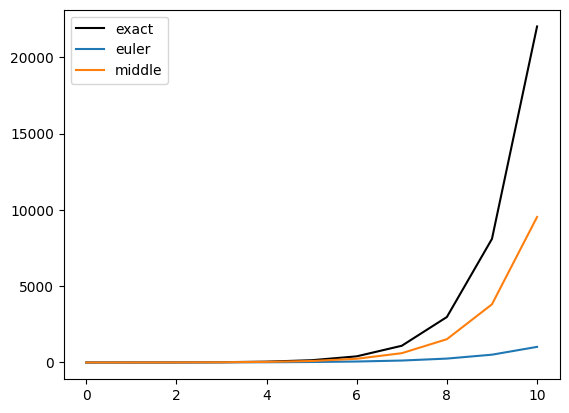

In [7]:
times_e, y_e = propagate(t_0=0, 
                         y_0=1, 
                         delta_t=1, 
                         n_steps=11, 
                         func=deriv_exp)


times_m, y_m = propagate(t_0=0, 
                         y_0=1, 
                         delta_t=1, 
                         n_steps=11, 
                         func=deriv_exp, 
                         method='middle')

plt.plot(times_e, np.exp(times_e), label='exact', color='black')
plt.plot(times_e, y_e, label='euler')
plt.plot(times_m, y_m, label='middle')

plt.legend()

We can also compare how the size of the timestep will affect the result. Before that, we could
create a function that will tell me how many timesteps to use, given the size of the timestep
and the last time you want to compute

In [8]:
def compute_n_steps(delta_t, t_max, t_min = 0.0):
    """
    Compute the number of steps from initial time up to max time
    for a given timestep.

    Parameters
    ----------
    delta_t : float
        Size of the timestep
    t_max : float
        Maximum time of the simulation
    t_min : float, optional
        Initial time of the simulation. By default 0.0

    Returns
    -------
    int
        Number of timesteps the simulation will take
    """
    return int((t_max-t_min)/delta_t) + 1

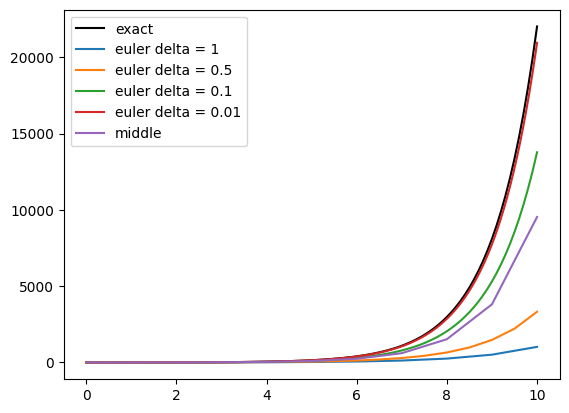

In [9]:
t_0 = 0
y_0 = 1
tmax = 10

# propagating with Euler using a timestep of 1
times_e1, y_e1 = propagate(t_0=t_0, 
                           y_0=y_0, 
                           delta_t=1, 
                           n_steps=compute_n_steps(1, tmax), 
                           func=deriv_exp)

# propagating with Euler using a timestep of 0.5
times_e05, y_e05 = propagate(t_0=t_0, 
                             y_0=y_0, 
                             delta_t=0.5, 
                             n_steps=compute_n_steps(0.5, tmax), 
                             func=deriv_exp)

# propagating with Euler using a timestep of 0.1
times_e01, y_e01 = propagate(t_0=t_0, 
                             y_0=y_0, 
                             delta_t=0.1, 
                             n_steps=compute_n_steps(0.1, tmax), 
                             func=deriv_exp)

# propagating with Euler using a timestep of 0.01
times_e001, y_e001 = propagate(t_0=t_0, 
                               y_0=y_0, 
                               delta_t=0.01, 
                               n_steps=compute_n_steps(0.01, tmax), 
                               func=deriv_exp)

# propagating with middle point using a timestep of 1
times_m, y_m = propagate(t_0=t_0, 
                         y_0=y_0, 
                         delta_t=1, 
                         n_steps=compute_n_steps(1, tmax), 
                         func=deriv_exp, 
                         method='middle')

plt.plot(times_e01, np.exp(times_e01), label='exact', color='black')
plt.plot(times_e1,   y_e1,   label='euler delta = 1')
plt.plot(times_e05,  y_e05,  label='euler delta = 0.5')
plt.plot(times_e01,  y_e01,  label='euler delta = 0.1')
plt.plot(times_e001, y_e001, label='euler delta = 0.01')
plt.plot(times_m,    y_m,    label='middle')

plt.legend()

In [10]:
# PRACTICE: what happens if you increase max time? And reduce max time?
# what timestep euler has to use to approximate middle point?
# What would be best to use, higher order or smaller timestep?

# Solving with an external library (scipy)
Even for the exponential function, that is relatively simple, it's necessary to use a very small
timestep to remain close to the real solution. In the long time scale, all solutions will deviate.

We can take a look at how those methods behave for a more complicated problem:

$$
y = \frac{sin(3t)}{ln(t+1.1)} \\
y' = \frac{3cos(3t)ln(t+1.1) - sin(3t)/(t+1.1)}{ln(t+1.1)^2}
$$

Define in the following functions

In [11]:
def func(t):
    """Test function.

    Parameters
    ----------
    t : float
        Time to evaluate the function

    Returns
    -------
    float
        Value of the function at time t.
    """
    
    return np.sin(3*t)/np.log(t+1.1)

In [12]:
def deriv_func(t, y):
    """Derivative of the test function.

    Parameters
    ----------
    t : float
        Time to evaluate the function
    y : float
        Value of y at time t

    Returns
    -------
    float
        Derivative of y
    """
    
    numerator = 3*np.log(t+1.1)*np.cos(3*t) - np.sin(3*t)/(t+1.1)
    denominator = np.log(t+1.1)**2

    return numerator/denominator

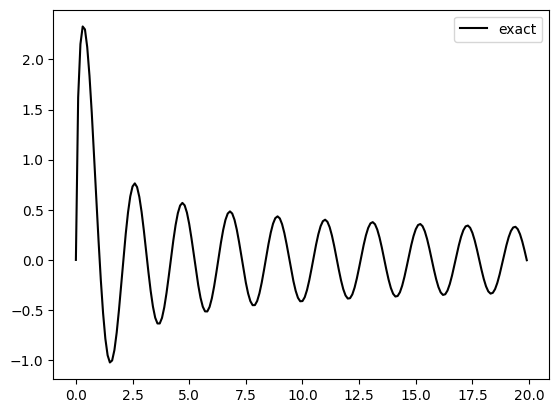

In [13]:
times = np.arange(0, 20, 0.1)
y_exact = func(times)

plt.plot(times, y_exact, label='exact', color='black')
plt.legend()

Using a very small timestep for the previous methods, we have the following solutions

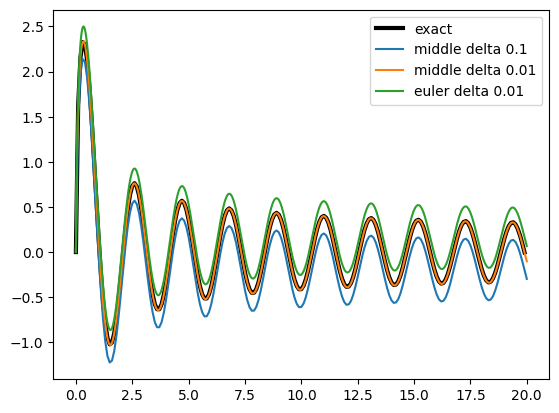

In [14]:
t_0 = 0
y_0 = 0
delta_t = 0.01
tmax = 20

times_e, y_e = propagate(t_0=t_0, 
                         y_0=y_0, 
                         delta_t=delta_t, 
                         n_steps=compute_n_steps(delta_t, tmax), 
                         func=deriv_func, 
                         method='euler')

times_m001, y_m001 = propagate(t_0=t_0, 
                               y_0=y_0, 
                               delta_t=delta_t, 
                               n_steps=compute_n_steps(delta_t, tmax), 
                               func=deriv_func, 
                               method='middle')

delta_t = 0.1
times_m01, y_m01 = propagate(t_0=t_0, 
                             y_0=y_0, 
                             delta_t=delta_t, 
                             n_steps=compute_n_steps(delta_t, tmax), 
                             func=deriv_func, 
                             method='middle')

plt.plot(times, y_exact, label='exact', color='black', linewidth=3)
plt.plot(times_m01, y_m01, label='middle delta 0.1')
plt.plot(times_m001, y_m001, label='middle delta 0.01')
plt.plot(times_e, y_e, label='euler delta 0.01')
plt.legend()

We notice that the middle point method needs a very small timestep to give a good result, and the 
Euler method deviates from the exact result even with the very small step size.

We could attempt to write a higher order method, but this is a good moment to use another python
library, developed for scientific applications, [SciPy](https://docs.scipy.org/doc/scipy/tutorial/index.html).

In the line:
> from scipy.integrate import solve_ivp

we told python that from the library scipy we want the methods in integrate, and from those methods
we want to import specifically *solve_ivp*. This is the method used to solve an initial value 
problem. In the reference page for this function:

https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.solve_ivp.html#scipy.integrate.solve_ivp

you'll find all the possible parameters you can use for this function. Of those parameters, we will
be interested in:
- fun : the derivative function we are trying to solve
- t_span : a sequence of two values, the initial time and the final time of the integration
- y0 : the initial value for the variables of t we are trying to obtain

You can then use the function in the following way:

In [15]:
sol = solve_ivp(fun=deriv_func, 
                t_span=[0, 20], 
                y0=[0])
print(sol)

  message: 'The solver successfully reached the end of the integration interval.'
     nfev: 212
     njev: 0
      nlu: 0
      sol: None
   status: 0
  success: True
        t: array([0.00000000e+00, 1.00000000e-04, 1.10000000e-03, 1.11000000e-02,
       7.02311205e-02, 1.82989238e-01, 4.02051811e-01, 8.33855615e-01,
       1.76015522e+00, 2.68645482e+00, 3.47653349e+00, 4.25332164e+00,
       5.01646774e+00, 6.00911129e+00, 6.90296187e+00, 7.72031816e+00,
       8.47655145e+00, 9.24100358e+00, 1.01805492e+01, 1.10560647e+01,
       1.18543524e+01, 1.26061026e+01, 1.33784441e+01, 1.42218936e+01,
       1.50329401e+01, 1.57835867e+01, 1.65523530e+01, 1.76926807e+01,
       1.86627530e+01, 1.95322320e+01, 2.00000000e+01])
 t_events: None
        y: array([[ 0.        ,  0.00314462,  0.03426441,  0.31602927,  1.33042004,
         2.09409789,  2.29660736,  0.90582886, -0.80209331,  0.73522352,
        -0.55483911,  0.1145632 ,  0.33793771, -0.37354388,  0.46079772,
        -0.4228446 ,  

Looking at the result of the function, we see that we successfully reached the final time, 
we also see that the time is an array called t and that the value of the function is an array
called y. This type of thing is also explained in SciPy's web page. Then we can use t and y to plot
this solution.

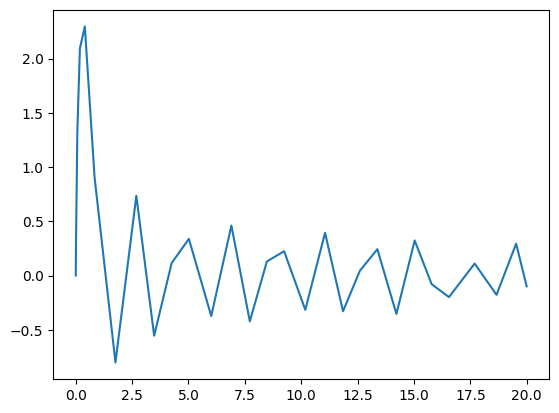

In [16]:
plt.plot(sol.t, sol.y[0])

At first it might seem that this is a horrible result, but it only seems that way because we needed
to use a small amount of points, decided by the function

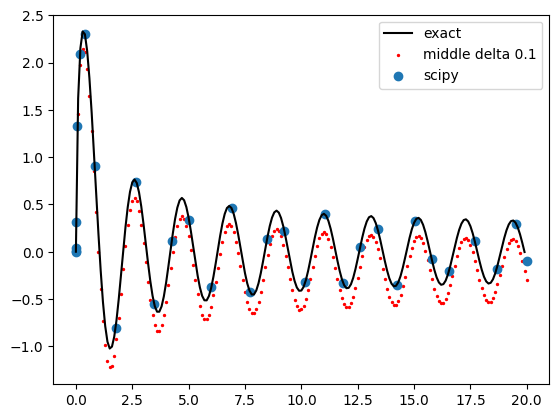

In [17]:
plt.plot(times, y_exact, label='exact', color='black')
plt.scatter(times_m01, y_m01, s=2, label='middle delta 0.1', color='red')
plt.scatter(sol.t, sol.y[0], label='scipy')
plt.legend()

Comparing with the middle point solution that used a timestep of 0.1, we are much closer to the
correct result and with very fewer evaluations. In a problem where it takes time to compute the
derivative function, this is very important.

Looking at the documentation of SciPy, we can find the option *t_eval*, where you give a list of
times to return the result. It will still propagate the same as before, but before returning the
result to us it will interpolate the points. With this you continue to use only a few evaluations
of the derivative function, but also return a lot of point, in case this is necessary.

In [18]:
sol = solve_ivp(fun=deriv_func, 
                t_span=[0, 20], 
                y0=[0],
                t_eval=times_m01[:-1])
print(sol)

  message: 'The solver successfully reached the end of the integration interval.'
     nfev: 212
     njev: 0
      nlu: 0
      sol: None
   status: 0
  success: True
        t: array([ 0. ,  0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7,  0.8,  0.9,  1. ,
        1.1,  1.2,  1.3,  1.4,  1.5,  1.6,  1.7,  1.8,  1.9,  2. ,  2.1,
        2.2,  2.3,  2.4,  2.5,  2.6,  2.7,  2.8,  2.9,  3. ,  3.1,  3.2,
        3.3,  3.4,  3.5,  3.6,  3.7,  3.8,  3.9,  4. ,  4.1,  4.2,  4.3,
        4.4,  4.5,  4.6,  4.7,  4.8,  4.9,  5. ,  5.1,  5.2,  5.3,  5.4,
        5.5,  5.6,  5.7,  5.8,  5.9,  6. ,  6.1,  6.2,  6.3,  6.4,  6.5,
        6.6,  6.7,  6.8,  6.9,  7. ,  7.1,  7.2,  7.3,  7.4,  7.5,  7.6,
        7.7,  7.8,  7.9,  8. ,  8.1,  8.2,  8.3,  8.4,  8.5,  8.6,  8.7,
        8.8,  8.9,  9. ,  9.1,  9.2,  9.3,  9.4,  9.5,  9.6,  9.7,  9.8,
        9.9, 10. , 10.1, 10.2, 10.3, 10.4, 10.5, 10.6, 10.7, 10.8, 10.9,
       11. , 11.1, 11.2, 11.3, 11.4, 11.5, 11.6, 11.7, 11.8, 11.9, 12. ,
       12.1, 12.2,

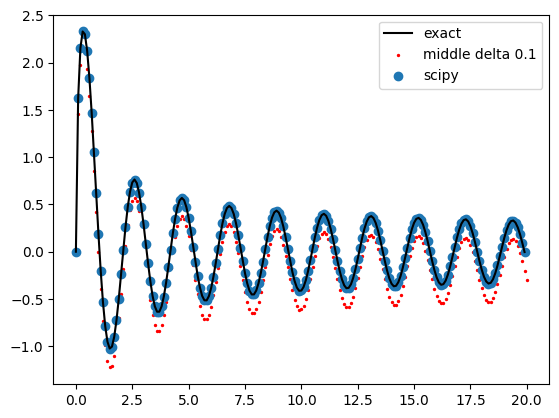

In [19]:
plt.plot(times, y_exact, label='exact', color='black')
plt.scatter(times_m01, y_m01, s=2, label='middle delta 0.1', color='red')
plt.scatter(sol.t, sol.y[0], label='scipy')
plt.legend()

You can then call *solve_ivp* from a function inside your program, or consult the web page and test
with different integration methods. 

The use of the external libraries can facilitate the work, if you are able to represent the problem
in the appropriate way.